<a href="https://colab.research.google.com/github/JN513/visao-computacional/blob/master/notebooks/mask_detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Detector de pessoas com  mascaras, com python e tensorflow

dataset: https://github.com/gorpo/Face-Recognition-Detector-de-Mascara-Python-Covid-19/

baseado em: https://github.com/gorpo/Face-Recognition-Detector-de-Mascara-Python-Covid-19/

In [4]:
!git clone https://github.com/gorpo/Face-Recognition-Detector-de-Mascara-Python-Covid-19.git
!mkdir /content/classificadores/
!cp /content/Face-Recognition-Detector-de-Mascara-Python-Covid-19/detectores/deploy.prototxt /content/classificadores/deploy.txt 
!cp /content/Face-Recognition-Detector-de-Mascara-Python-Covid-19/detectores/res10_300x300_ssd_iter_140000.caffemodel /content/classificadores/res10_300x300_ssd_iter_140000.caffemodel

fatal: destination path 'Face-Recognition-Detector-de-Mascara-Python-Covid-19' already exists and is not an empty directory.
mkdir: cannot create directory ‘/content/classificadores/’: File exists


In [6]:
from google.colab.patches import cv2_imshow
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import PIL
from PIL import Image

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import cv2
import os

In [7]:
print('[INFO] Carregando imagens ...')
#carregando imagens
caminho_imagens = list(paths.list_images('/content/Face-Recognition-Detector-de-Mascara-Python-Covid-19/dataset'))

imagens = []
labels = []
#pegando o label e a imagem e add em listas
for path in caminho_imagens:
    label = path.split(os.path.sep)[-2]
    #abrindo e processando as imagens
    imagem = load_img(path, target_size=(224, 224))
    imagem = img_to_array(imagem)
    imagem = preprocess_input(imagem)

    imagens.append(imagem)
    labels.append(label)

#transformando em array numpy
imagens = np.array(imagens, dtype='float32')
labels = np.array(labels)

[INFO] Carregando imagens ...


In [8]:
# executar codificação one-hot nas etiquetas
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [9]:
# particione os dados em divisões de treinamento e teste usando 75% dos dados para treinamento e os 25% restantes para teste
(trainX, testX, trainY, testY) = train_test_split(imagens, labels, test_size=0.20, stratify=labels, random_state=42)

In [10]:
# construindo o gerador de imagens de treinamento para aumento de dados
gerador = ImageDataGenerator(rotation_range=20, zoom_range=0.15, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15, horizontal_flip=True, fill_mode="nearest")

# carregando a rede MobileNetV2, garantindo que os conjuntos de camadas FC principais sejam deixados de lado
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=keras.layers.Input(shape=(224, 224, 3)))

# construindo a cabeça do modelo que será colocado em cima do modelo base
modelo_cabeca = baseModel.output
modelo_cabeca = keras.layers.AveragePooling2D(pool_size=(7, 7))(modelo_cabeca)
modelo_cabeca = keras.layers.Flatten(name="flatten")(modelo_cabeca)
modelo_cabeca = keras.layers.Dense(128, activation="relu")(modelo_cabeca)
modelo_cabeca = keras.layers.Dropout(0.5)(modelo_cabeca)
modelo_cabeca = keras.layers.Dense(2, activation="softmax")(modelo_cabeca)

#criando o modelo principal sobre o base
modelo = Model(inputs=baseModel.input, outputs=modelo_cabeca)

# percorre todas as camadas no modelo base e as congela para que elas * não * sejam atualizadas durante o primeiro processo de treinamento
for layer in baseModel.layers:
	  layer.trainable = False

#compilando o modelo
print('[INFO] compilando modelo ...')

modelo.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

9412608/9406464 [==============================] - 0s 0us/step
[INFO] compilando modelo ...


In [11]:
# inicialize a taxa de aprendizado inicial, número de épocas para treinamento e tamanho do lote
inicia_apredizado = 1e-4
quantidade_treinos = 30
tamanho_lote = 32

# treinar a cabeça
print("[INFO] treinando...")
cabeca = modelo.fit(gerador.flow(trainX, trainY, batch_size=tamanho_lote), steps_per_epoch=len(trainX) // tamanho_lote, validation_data=(testX, testY), validation_steps=len(testX) // tamanho_lote, epochs=quantidade_treinos)

[INFO] treinando...
Epoch 1/30
29/29 [==============================] - 46s 2s/step - loss: 0.1922 - accuracy: 0.9300 - val_loss: 0.0059 - val_accuracy: 1.0000
Epoch 2/30
29/29 [==============================] - 44s 2s/step - loss: 0.0261 - accuracy: 0.9911 - val_loss: 0.0109 - val_accuracy: 0.9957
Epoch 3/30
29/29 [==============================] - 44s 2s/step - loss: 0.0221 - accuracy: 0.9922 - val_loss: 0.0045 - val_accuracy: 1.0000
Epoch 4/30
29/29 [==============================] - 44s 2s/step - loss: 0.0233 - accuracy: 0.9922 - val_loss: 0.0046 - val_accuracy: 0.9957
Epoch 5/30
29/29 [==============================] - 44s 2s/step - loss: 0.0086 - accuracy: 0.9967 - val_loss: 0.0038 - val_accuracy: 1.0000
Epoch 6/30
29/29 [==============================] - 44s 2s/step - loss: 0.0132 - accuracy: 0.9967 - val_loss: 0.0067 - val_accuracy: 0.9957
Epoch 7/30
29/29 [==============================] - 44s 2s/step - loss: 0.0134 - accuracy: 0.9944 - val_loss: 0.0022 - val_accuracy: 1.0000


In [12]:
# fazendo predições na rede neural
print("[INFO] avaliando a rede neural...")
predIdxs = modelo.predict(testX, batch_size=tamanho_lote)

# para cada imagem no conjunto de testes, precisamos encontrar o índice do rótulo com a maior probabilidade prevista correspondente
predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(testY.argmax(axis=1), predIdxs,	target_names=lb.classes_))

[INFO] avaliando a rede neural...
              precision    recall  f1-score   support

 com_mascara       0.99      1.00      1.00       113
 sem_mascara       1.00      0.99      1.00       120

    accuracy                           1.00       233
   macro avg       1.00      1.00      1.00       233
weighted avg       1.00      1.00      1.00       233



In [13]:
# salvando o modelo
print("[INFO] salvando o modelo...")
modelo.save("/content/classificadores/mask_detector.model", save_format="h5")

[INFO] salvando o modelo...


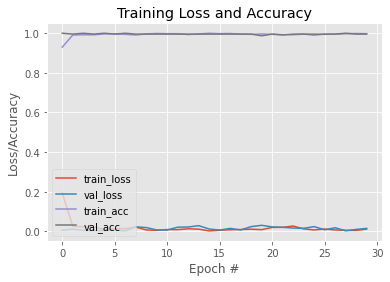

In [14]:
# traçar a perda e a precisão do treinamento
N = quantidade_treinos
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), cabeca.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), cabeca.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), cabeca.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), cabeca.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1


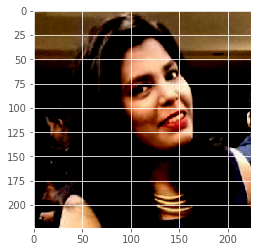

In [15]:
predIdxs = modelo.predict(testX)
predIdxs = np.argmax(predIdxs[0])
print(predIdxs)

plt.imshow(testX[0])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)
0.9954999
0.0045001227
0


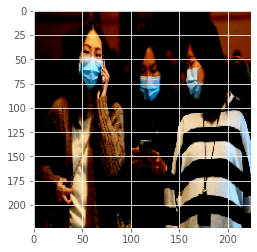

In [16]:
path="/content/Face-Recognition-Detector-de-Mascara-Python-Covid-19/exemplos/1.png"

imagem = load_img(path, target_size=(224, 224))
imagem = img_to_array(imagem)
imagem = preprocess_input(imagem)

imagem = np.array(imagem, dtype='float32')
print(imagem.shape)
imagens = [imagem]
imagens = np.array(imagens, dtype='float32')

(mask, withoutMask) = modelo.predict(imagens)[0]
print(mask)
print(withoutMask)
predIdxs = modelo.predict(imagens)
predIdxs = np.argmax(predIdxs)
print(predIdxs)

plt.imshow(imagem)
plt.show()

In [19]:
#mostrar mascara em uma imagem

# carrega modelo de detector de rosto serializado a partir do disco
print("[INFO] carregando modelo detector de faces...")
prototxtPath = os.path.sep.join(["/content/classificadores/deploy.txt"])
weightsPath = os.path.sep.join(	["/content/classificadores/res10_300x300_ssd_iter_140000.caffemodel"])
net = cv2.dnn.readNet(prototxtPath, weightsPath)

# carregar o modelo do detector de máscara facial a partir do disco
print("[INFO] carregando modelo...")
modelo = load_model("/content/classificadores/mask_detector.model")

[INFO] carregando modelo detector de faces...
[INFO] carregando modelo...


In [20]:
#carrega a imagem
print("[INFO] carregando imagem...")
imagem = cv2.imread('/content/Face-Recognition-Detector-de-Mascara-Python-Covid-19/exemplos/1.png')
#copiando imagem
origem = imagem.copy()
(h, w) = imagem.shape[:2]

[INFO] carregando imagem...


In [22]:
# construir um blob a partir da imagem
blob = cv2.dnn.blobFromImage(imagem, 1.0, (300, 300), (104.0, 177.0, 123.0))
# passe o blob pela rede e obtenha as detecções de rosto

print("[INFO] computando deteccoes faciais...")
net.setInput(blob)
deteccoes = net.forward()

[INFO] computando deteccoes faciais...


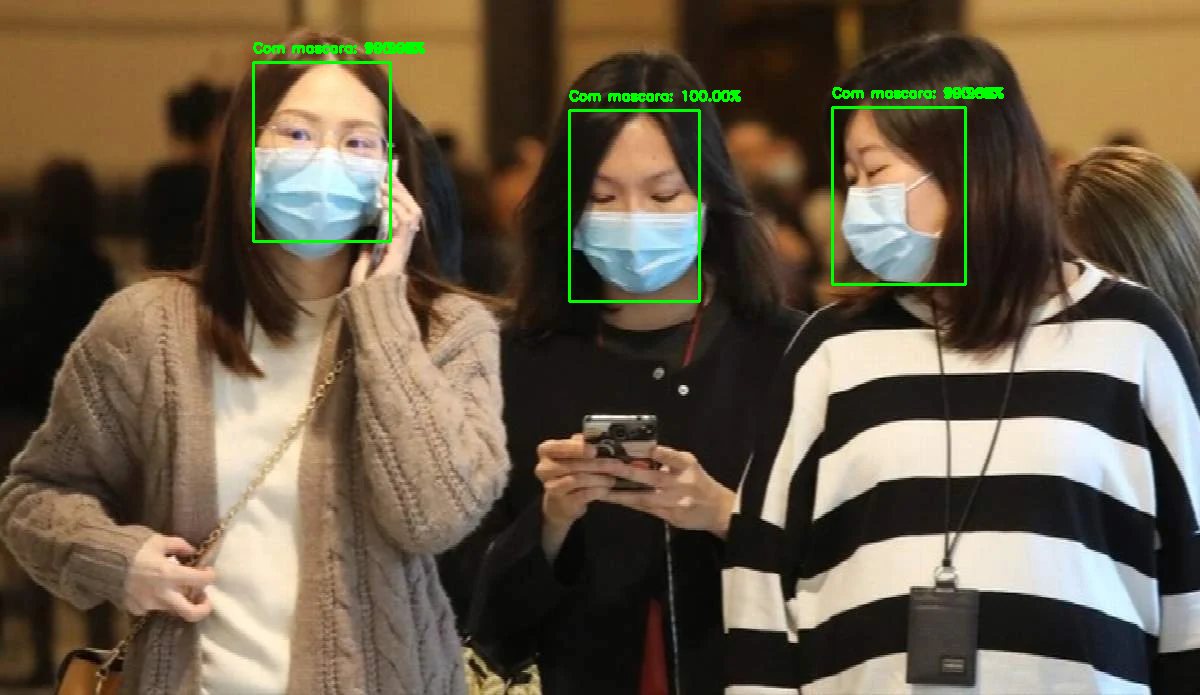

In [24]:
# loop sobre as detecçoes
for i in range(0, deteccoes.shape[2]):
	# extrair a confiança (ou seja, probabilidade) associada à detecção
    confianca = deteccoes[0, 0, i, 2]
    # filtrar detecções fracas, garantindo que a confiança seja maior que a confiança mínima
    if confianca > 0.5:
        # calcular as coordenadas (x, y) da caixa delimitadora para o objeto
        box = deteccoes[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")
        # verifique se as caixas delimitadoras estão dentro das dimensões do 
        
        (startX, startY) = (max(0, startX), max(0, startY))
        (endX, endY) = (min(w - 1, endX), min(h - 1, endY))		
        
		# extrai o ROI da face, converte-o de pedido de canal BGR para RGB, redimensione-o para 224x224 e pré-processe
        face = imagem[startY:endY, startX:endX]
        face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        face = cv2.resize(face, (224, 224))
        face = img_to_array(face)
        face = preprocess_input(face)
        face = np.expand_dims(face, axis=0)

		# passa a iamgem no modelo, para verificar a exixtencia de uma mascara ou não
        (mask, withoutMask) = modelo.predict(face)[0]

        #determinado a label e a cor do quadrado
        label = "Com mascara" if mask > withoutMask else "Sem mascara"
        color = (0, 255, 0) if label == "Com mascara" else (0, 0, 255)

		# inclui a probabilidade na label
        label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
		# exibir a label e o retângulo da caixa delimitadora no quadro de saída

        cv2.putText(imagem, label, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(imagem, (startX, startY), (endX, endY), color, 2)

# Mostra a imagem final
cv2_imshow(imagem)